Мультивариативный ряд: история цен и объём торгов курса эфириума к доллару США.<br>
Данные охватывают период за c января 2020 года по март 2021 года.<br>
Решаем задачу регресии. Предсказываем цены.

1. Мультивариативный ряд
2. Задача классификации или задача регрессии
3. Блок предобрабоки временного ряда
4. Не менее 3х способов выделения свойств из временного ряда
5. Не менее 2 классических  и 3 нейронок для прогнозирования (или классификации) временного ряда
6. Не менее 5 метрик по каждой модели
7. Выводы по каждой модели, и по результатам в целом.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'data/gemini_ETHUSD_2020_1min.csv'
data = pd.read_csv(file_path, index_col=False)
del data['Symbol']
del data['Unix Timestamp']
del data['Volume']

data.reset_index(drop=True, inplace=True)


data = data.iloc[::-1].reset_index(drop=True)

In [2]:
data

,Date,Open,High,Low,Close
0,1/1/2020 0:00,128.84,128.84,128.74,128.74
1,1/1/2020 0:01,128.74,128.74,128.74,128.74
2,1/1/2020 0:02,128.74,128.74,128.74,128.74
3,1/1/2020 0:03,128.74,128.74,128.74,128.74
4,1/1/2020 0:04,128.74,128.74,128.49,128.50
...,...,...,...,...,...
658054,4/19/2021 23:59,2166.54,2166.54,2162.36,2162.69
658055,4/20/2021 0:00,2162.69,2176.00,2162.69,2172.16
658056,4/20/2021 0:01,2172.16,2177.59,2168.63,2168.63
658057,4/20/2021 0:02,2168.63,2168.63,2155.88,2155.88


Данные были обрезаны до 50000 в силу экономии времени. Как бы не хотелось, но огромное количество данных сильно влияет на скорость обучения моделей (даже тест Дики-Фуллера выполнялся 10 минут)

In [2]:
data = data[:50000]

## Блок предобработки временного ряда
### Свойства временных рядов

Просмотр основной информации о мультивариационном ряде

In [15]:
data

,Date,Open,High,Low,Close
0,1/1/2020 0:00,128.84,128.84,128.74,128.74
1,1/1/2020 0:01,128.74,128.74,128.74,128.74
2,1/1/2020 0:02,128.74,128.74,128.74,128.74
3,1/1/2020 0:03,128.74,128.74,128.74,128.74
4,1/1/2020 0:04,128.74,128.74,128.49,128.50
...,...,...,...,...,...
49995,2/7/2020 17:13,221.39,221.40,221.24,221.24
49996,2/7/2020 17:14,221.24,221.26,221.24,221.26
49997,2/7/2020 17:15,221.26,221.48,221.26,221.48
49998,2/7/2020 17:16,221.48,221.48,221.40,221.40


In [16]:
data.describe()

,Open,High,Low,Close
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,161.492210,161.536377,161.450697,161.494061
std,20.604069,20.614116,20.593835,20.604848
min,125.600000,125.600000,125.600000,125.600000
25%,143.130000,143.170000,143.090000,143.130000
50%,164.480000,164.565000,164.410000,164.480000
75%,175.330000,175.400000,175.310000,175.332500
max,224.090000,224.290000,224.090000,224.090000


Графики временных рядов

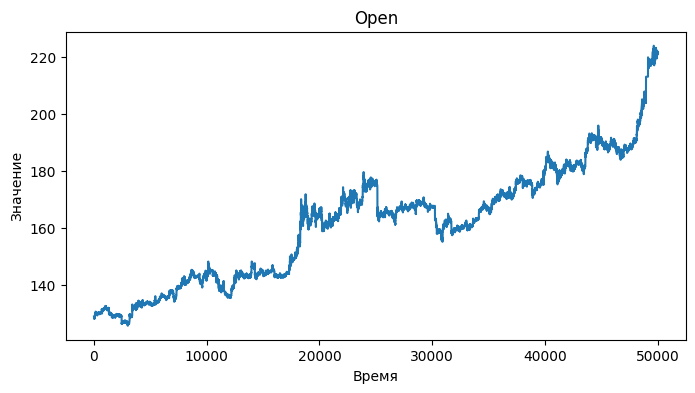

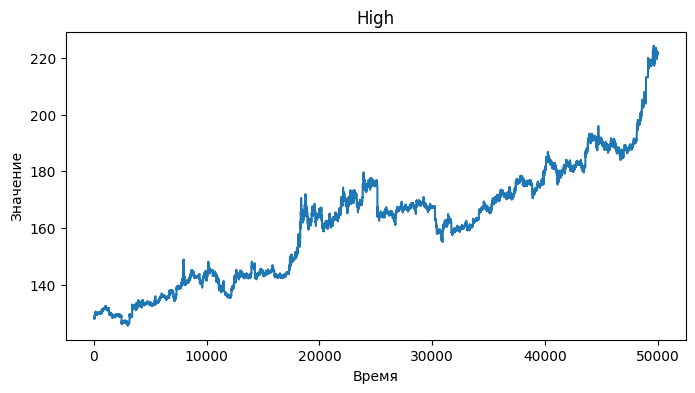

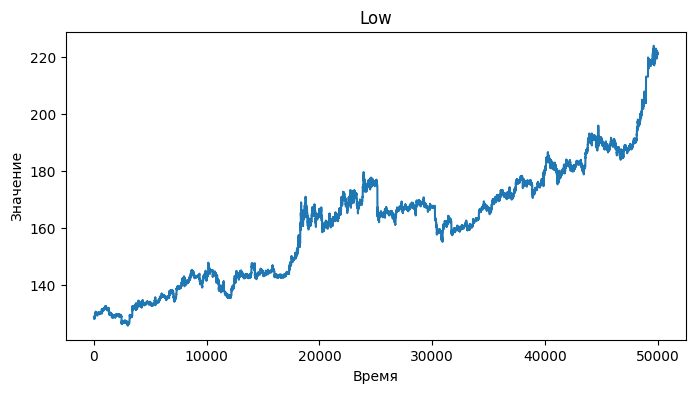

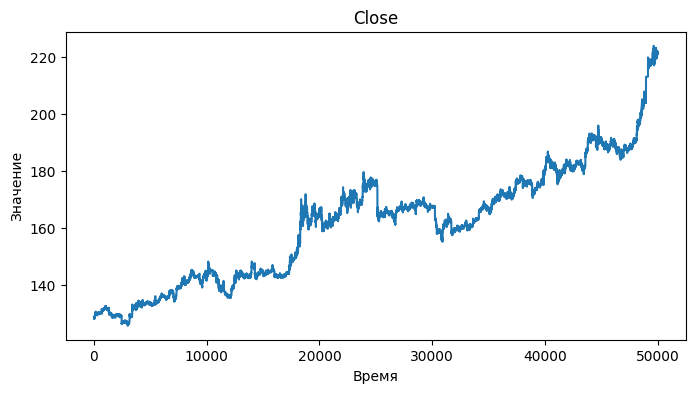

In [17]:
columns = data.columns

for column in columns:
    if column != 'Date':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

Проверка на то, что все данные передаются через равный промежуток времени. (1 минута)

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

time_diff = data['Date'].diff()

result = (time_diff == pd.Timedelta(minutes=1)).all()
result

False

Просмотр пропущенных значений во временном ряде

In [22]:
missing_values = data.isnull().sum()
missing_values

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

Посмотрим на составляющие временного ряда.

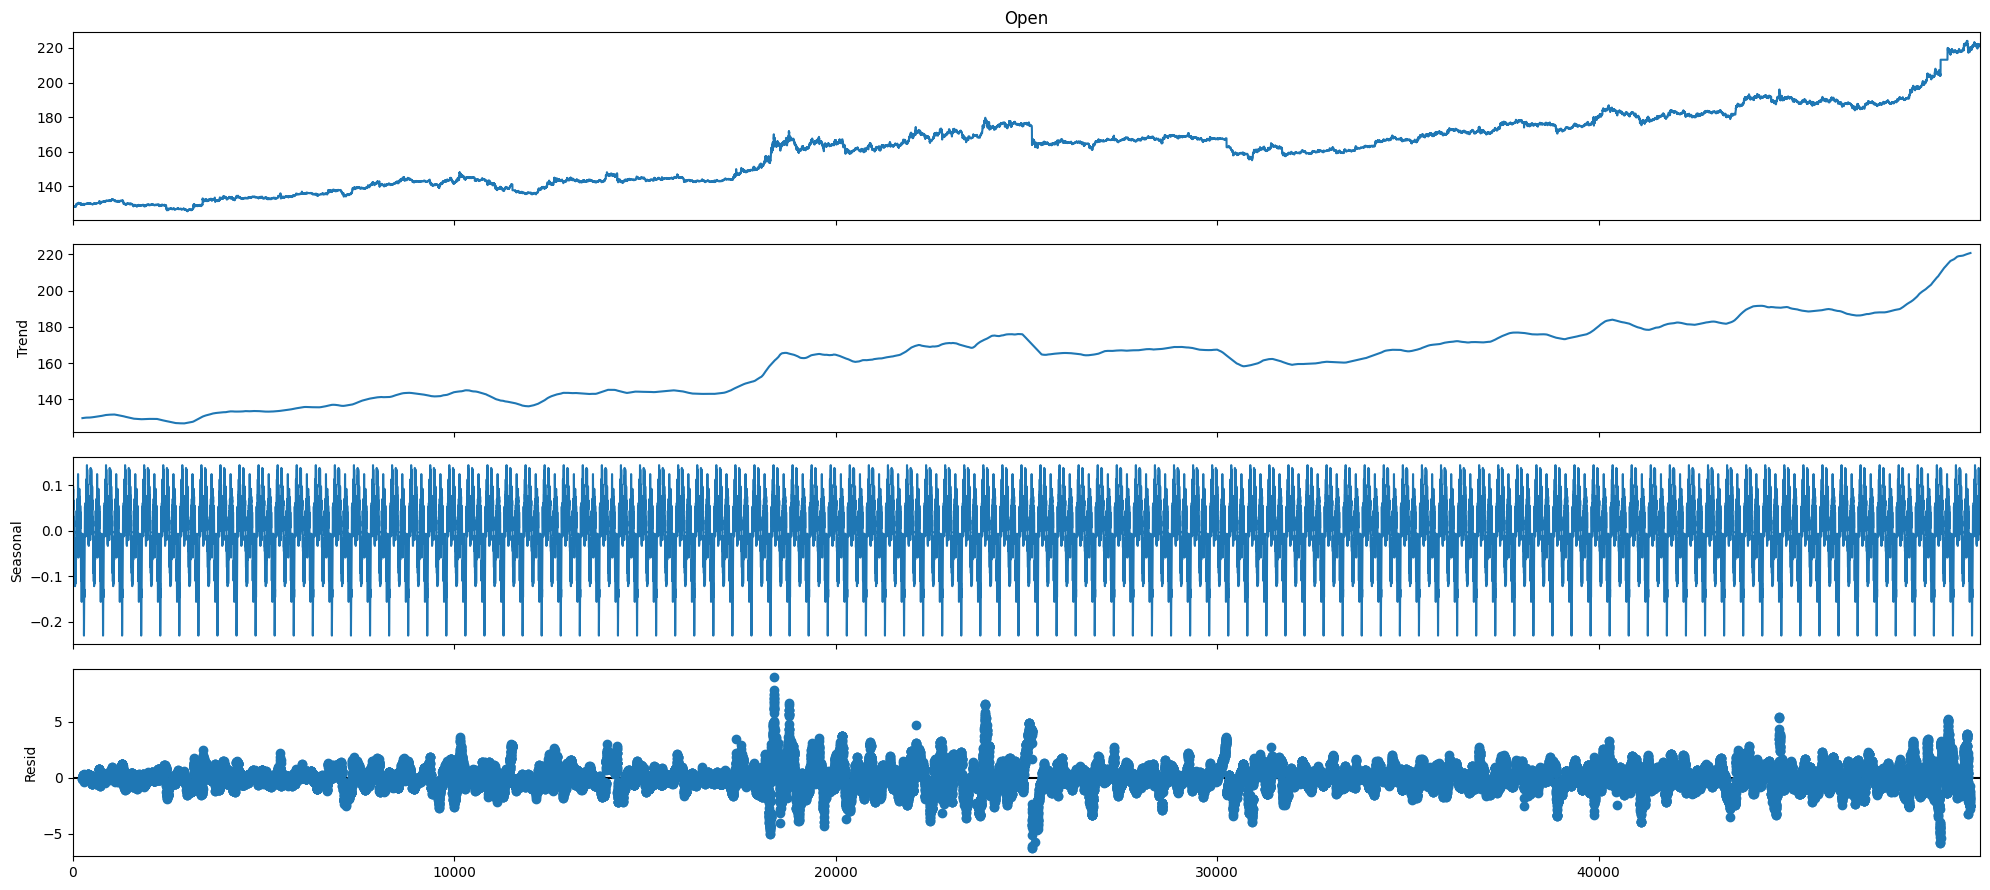

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 20, 9

decompose = seasonal_decompose(data['Open'], period=500)
decompose.plot()
plt.show()

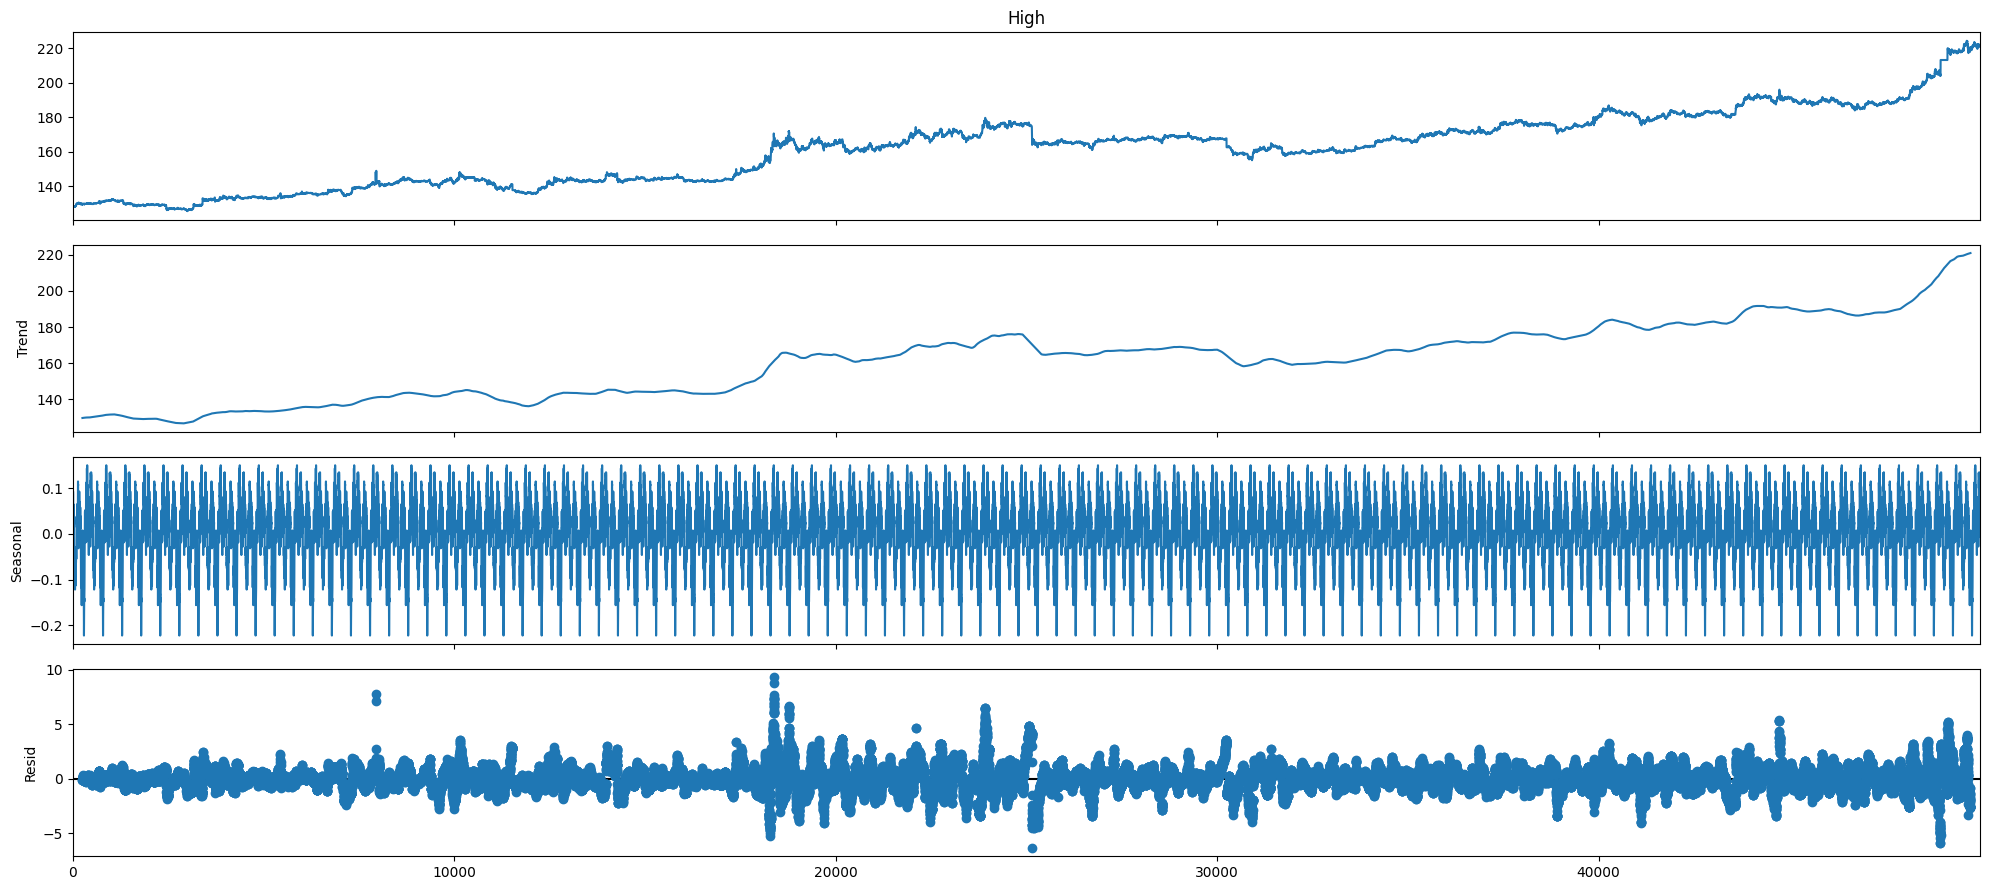

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 20, 9

decompose = seasonal_decompose(data['High'], period=500)
decompose.plot()
plt.show()

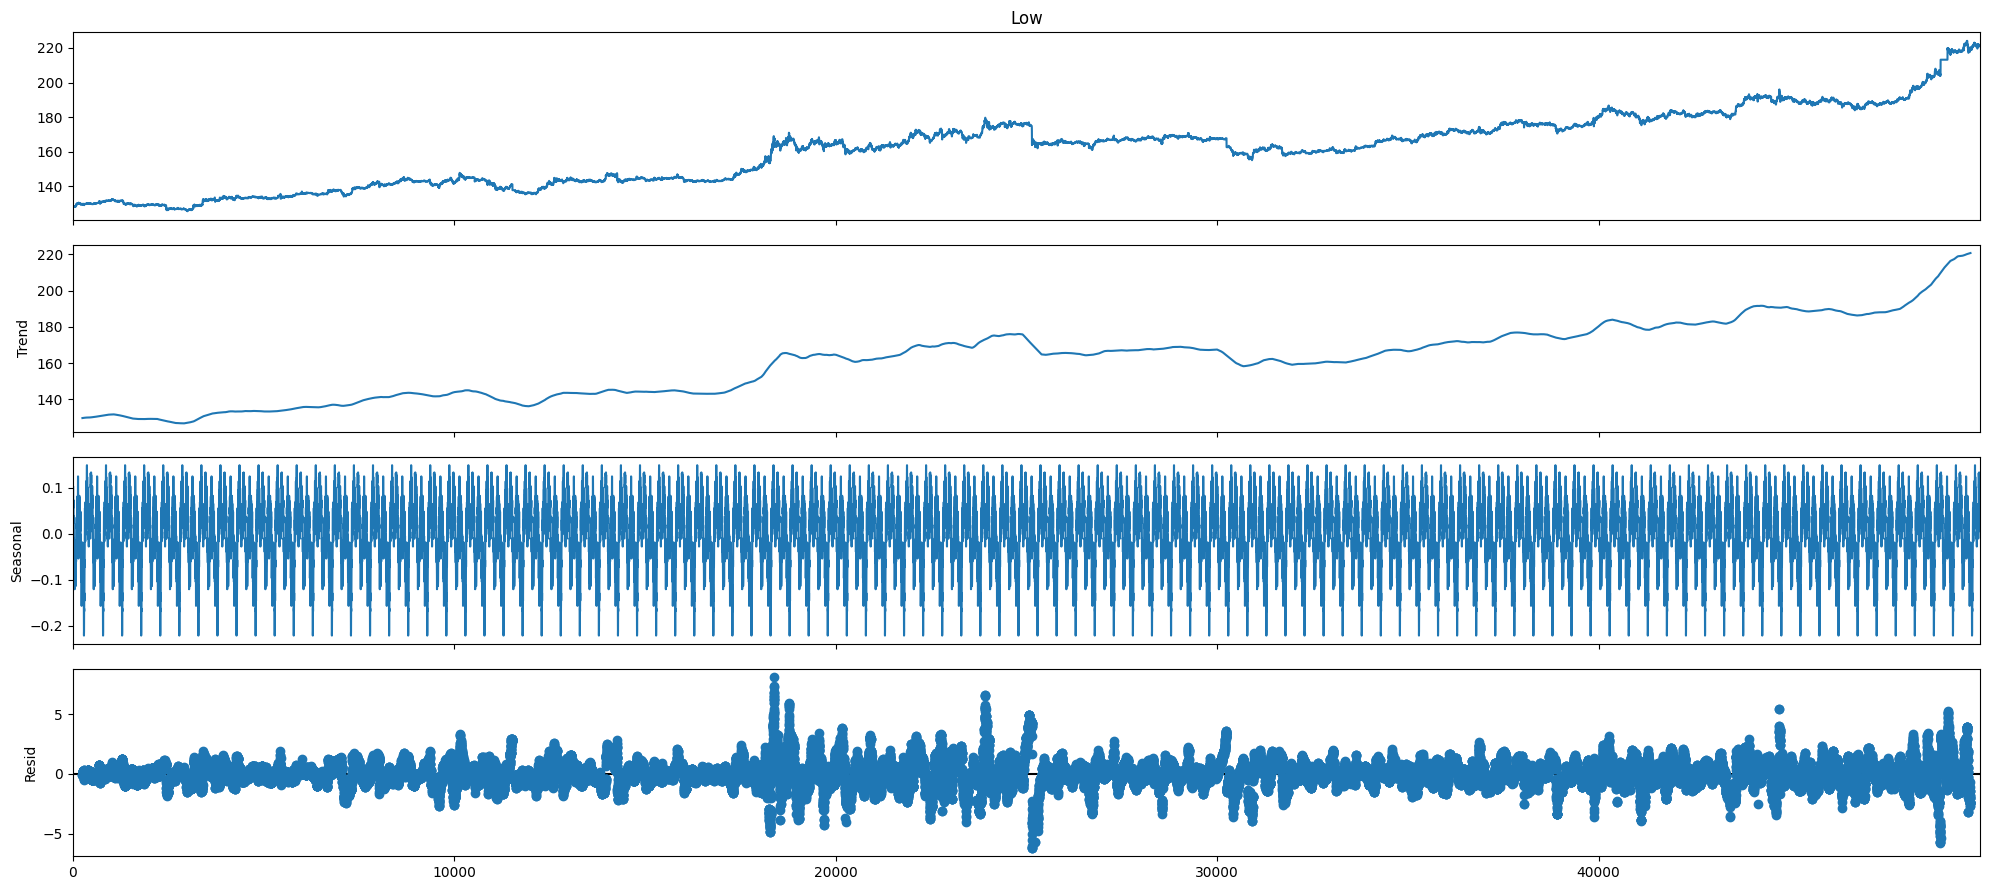

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 20, 9

decompose = seasonal_decompose(data['Low'], period=500)
decompose.plot()
plt.show()

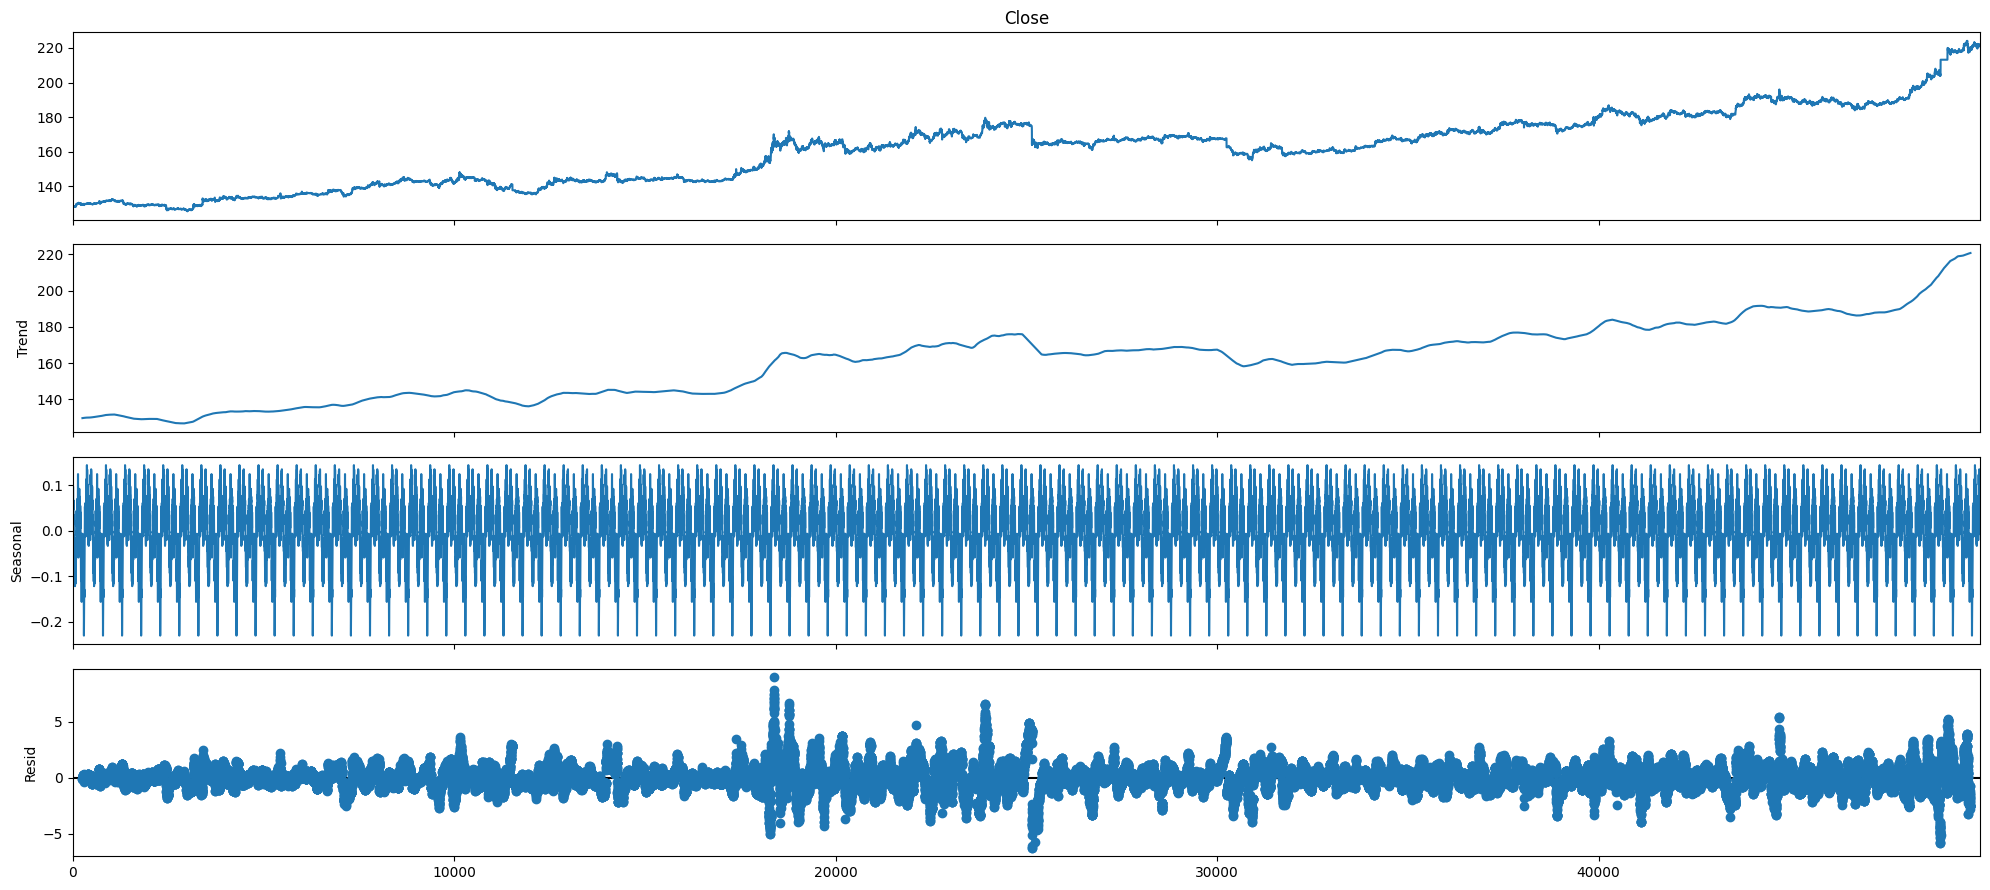

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 20, 9

decompose = seasonal_decompose(data['Close'], period=500)
decompose.plot()
plt.show()

Из графиков видно, что тренд отсутствуют, наблюдается сезонность.<br>

Проверка рядов на стационарность

In [27]:
from statsmodels.tsa.stattools import adfuller

def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [28]:
df_test("Open", data["Open"])

Тест Дики-Фуллера ряда Open:
Test Statistic                     0.891335
p-value                            0.992976
#Lags Users                       43.000000
Number of Observations Used    49956.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [29]:
df_test("High", data["High"])

Тест Дики-Фуллера ряда High:
Test Statistic                     0.800128
p-value                            0.991638
#Lags Users                       27.000000
Number of Observations Used    49972.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [30]:
df_test("Low", data["Low"])

Тест Дики-Фуллера ряда Low:
Test Statistic                     0.918553
p-value                            0.993328
#Lags Users                       47.000000
Number of Observations Used    49952.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [31]:
df_test("Close", data["Close"])

Тест Дики-Фуллера ряда Close:
Test Statistic                     0.889766
p-value                            0.992955
#Lags Users                       43.000000
Number of Observations Used    49956.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


Для прогнозирования в моделях VAR, VARMA важна стационарность.<br>
Для нейронок это уже необязательно.

Попробуем сезонное дифференцирование, чтобы сделать ряды стационарными.<br>

In [4]:
del data['Date']
lags = 15
differenced_series = data.diff(periods=lags).dropna()

Проверим

In [34]:
df_test("Open", differenced_series["Open"])

Тест Дики-Фуллера ряда Open:
Test Statistic                   -28.836026
p-value                            0.000000
#Lags Users                       55.000000
Number of Observations Used    49929.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [35]:
df_test("High", differenced_series["High"])

Тест Дики-Фуллера ряда High:
Test Statistic                   -28.976748
p-value                            0.000000
#Lags Users                       55.000000
Number of Observations Used    49929.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [36]:
df_test("Low", differenced_series["Low"])

Тест Дики-Фуллера ряда Low:
Test Statistic                   -28.870590
p-value                            0.000000
#Lags Users                       57.000000
Number of Observations Used    49927.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [37]:
df_test("Close", differenced_series["Close"])

Тест Дики-Фуллера ряда Close:
Test Statistic                   -28.871539
p-value                            0.000000
#Lags Users                       55.000000
Number of Observations Used    49929.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Коинтеграция

Коинтеграция временных рядов – причинно-следственная зависимость в уровнях двух и более временных рядов, которая выражается в совпадении или противоположной направленности тенденций данных рядов и случайной колеблемости.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).

In [38]:
from itertools import combinations
from statsmodels.tsa.stattools import coint

pairs = combinations(differenced_series.columns, 2)

for pair in pairs:
    pair_data = differenced_series[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])
    
    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между Open и High
Есть коинтеграция между Open и Low
Есть коинтеграция между Open и Close
Есть коинтеграция между High и Low
Есть коинтеграция между High и Close
Есть коинтеграция между Low и Close


Причинность рядов по Грейнджеру

In [432]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import warnings
from tqdm import tqdm

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value  
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(differenced_series, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


,Open_x,High_x,Low_x,Close_x,Volume_x
Open_y,1.0000,0.0,0.0,0.0000,0.0002
High_y,0.0000,1.0,0.0,0.0000,0.0000
Low_y,0.0000,0.0,1.0,0.0000,0.0000
Close_y,0.0000,0.0,0.0,1.0000,0.0013
Volume_y,0.0012,0.0,0.0,0.0012,1.0000


Если результат теста Грейнджера показывает строгое значение p-уровня значимости равное нулю или близкое к нулю (< 0.05) для пары временных рядов, это обычно интерпретируется как сильное статистическое доказательство в пользу наличия причинной связи между этими рядами. Ну и как итог - VAR модели подходят идеально.

#### Прогнозирование временного ряда

Первая модель - VAR. Для начала - подберем наилучший порядок, исходя из информационных критериев:<br>

AIC (Akaike Information Criterion)<br>
BIC (Bayesian Information Criterion)<br>
FPE (Final Prediction Error)<br>
HQC (Hannan-Quinn Criterion).<br> 

Меньшие значения критериев указывают на лучшую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [40]:
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np

train, test = differenced_series[:35000], differenced_series[35000:]

model = VAR(train)

orders = [2,6,12,20,24,30,40,48,50,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 2
AIC :  -18.011291122407727 
BIC :  -18.002585777443574 
FPE :  1.5058983367032757e-08 
HQIC:  -18.008518244699037  

Lag Order = 6
AIC :  -18.02707096200285 
BIC :  -18.002887010762052 
FPE :  1.4823220084409204e-08 
HQIC:  -18.019367705927746  

Lag Order = 12
AIC :  -18.046224437810412 
BIC :  -17.99881672536015 
FPE :  1.4542005703853511e-08 
HQIC:  -18.031123650338074  

Lag Order = 20
AIC :  -19.010137473442693 
BIC :  -18.93175381745248 
FPE :  5.546285345827222e-09 
HQIC:  -18.985169643117686  

Lag Order = 24
AIC :  -19.013274451804758 
BIC :  -18.919398138112545 
FPE :  5.528914161105403e-09 
HQIC:  -18.983371527425582  

Lag Order = 30
AIC :  -19.329623385660565 
BIC :  -19.212502225187368 
FPE :  4.0295010596481496e-09 
HQIC:  -19.29231585344581  

Lag Order = 40
AIC :  -19.452864782068183 
BIC :  -19.296986574677693 
FPE :  3.562281873881792e-09 
HQIC:  -19.40321098924101  

Lag Order = 48
AIC :  -19.688135431117956 
BIC :  -19.501237505124383 
FPE :  2.815474

Обучаем модель с наилучшим порядком (336)

In [41]:
model_fitted = model.fit(336)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 06, Jan, 2024
Time:                     20:05:04
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -18.9036
Nobs:                     34664.0    HQIC:                  -19.7975
Log likelihood:           159013.    FPE:                1.66160e-09
AIC:                     -20.2156    Det(Omega_mle):     1.42691e-09
--------------------------------------------------------------------
Results for equation Open
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000083         0.000186            0.447           0.655
L1.Open            0.000176         0.006220            0.028           0.977
L1.High            0.000121         0.002868            0.042           0

Теперь подготовим тестовые данные для предсказания, и сделаем их

In [42]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [43]:
X_test, Y_test = create_test_dataset(test, 336)
X_train, Y_train = create_train_dataset(train, 336)

In [44]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [46]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)

Y_train = np.array(Y_train)

Вернём исходные значения до сезонного дифференцирования

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

Метрики!!!!

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def smape_score(actual, predicted) -> float: 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual)) / 2) 
        ), 3
    ) 

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]
        
        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        
        validate(name, Y_true, Y_pred)

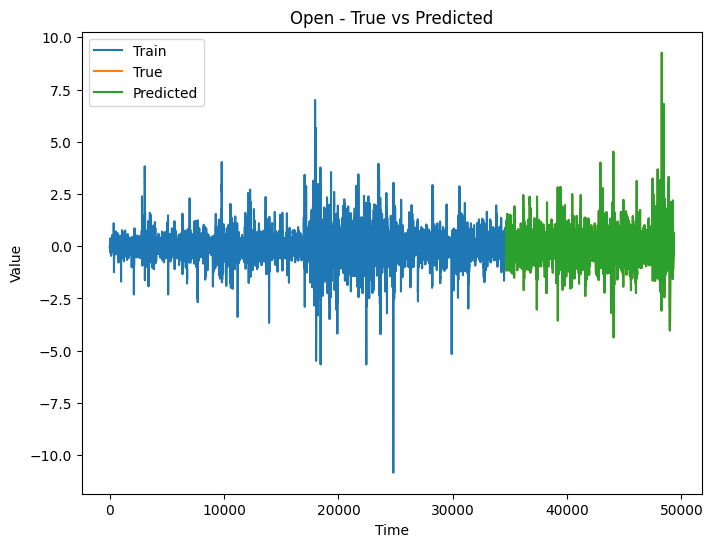

Метрики Open
MSE: 0.00515405558445404
RMSE: 0.07179175150707803
MAE: 0.00354853813099831
SMAPE: 0.069
R2: 0.9911405218653265 



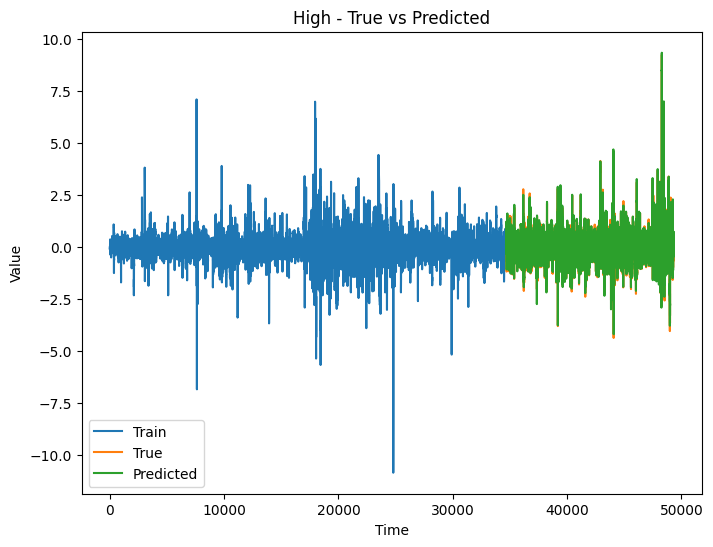

Метрики High
MSE: 0.0294453588642356
RMSE: 0.1715965001514763
MAE: 0.08694544265794824
SMAPE: 0.374
R2: 0.9492444839391931 



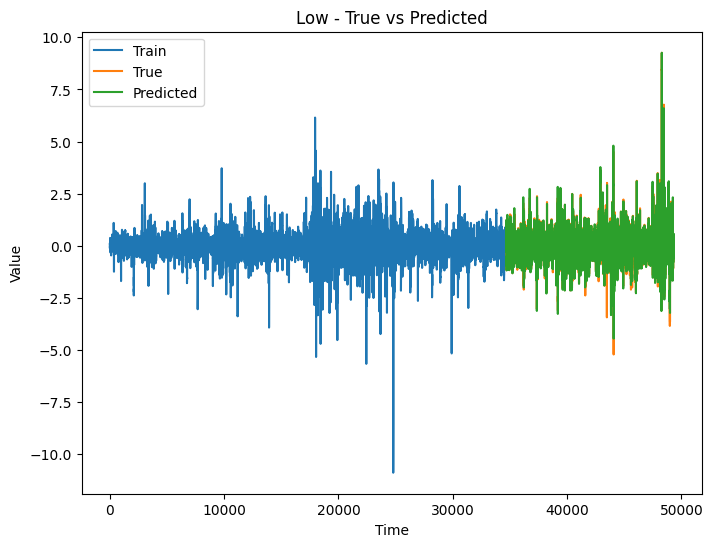

Метрики Low
MSE: 0.02852655087785233
RMSE: 0.16889804876863537
MAE: 0.08469274300249705
SMAPE: 0.37
R2: 0.9509737143867866 



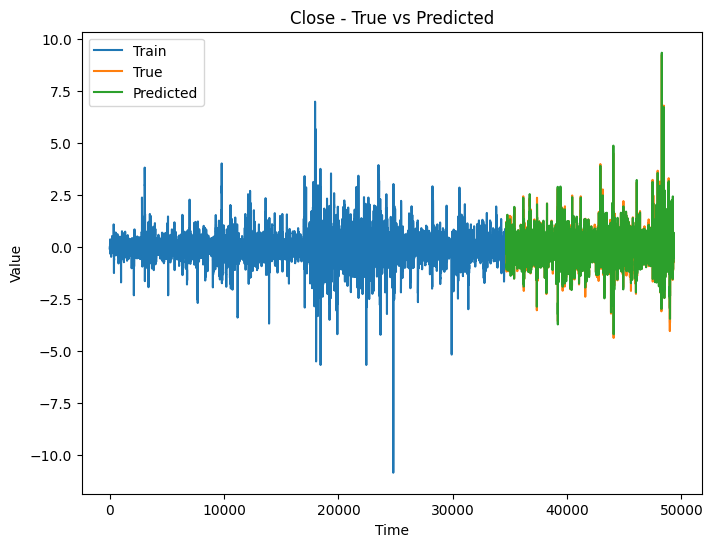

Метрики Close
MSE: 0.05157881029744966
RMSE: 0.22710968781064725
MAE: 0.12166589562769269
SMAPE: 0.464
R2: 0.91148300052944 



In [48]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

По метрикам:<br>

Адекватное MSE, RMSE, MAE - ниже единицы, что есть хорошо.<br>
SMAPE тоже показывает себя неплохо (чем ниже - тем лучше).<br>
По R2 - >0.9, хорошо, очень близко к единице.<br>



#### Следующая модель - VARMA

In [7]:
X = data
train, test = X[:35000], X[35000:]

In [8]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

Подберём оптимальные параметры для обучения при помощи AutoArima.<br>

In [9]:
from pmdarima import auto_arima

pq = []
for name, column in differenced_series.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Open
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20842.501, Time=18.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20732.285, Time=2.80 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20777.581, Time=2.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-20780.799, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20729.854, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-20828.391, Time=3.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-20827.714, Time=3.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-20827.711, Time=2.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20828.681, Time=1.89 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20829.550, Time=13.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-20837.932, Time=3.98 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 55.954 seconds
optimal order for:Open is: (1, 1, 1) 


Searching order of p and q for : High
Performing st

In [17]:
pq.remove((1, 1, 1)) # Удалим дублирующиеся параметры

In [18]:
pq

[(0, 1, 1), (2, 1, 0), (1, 1, 1)]

Определим функцию для обратного интегрирования

In [19]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

Подберем опытным путём наилучший порядок

In [28]:
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        inv_res = inverse_diff(data, result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(test['Open'], inv_res.Open_1st_inv_diff))
        Highrmse = np.sqrt(metrics.mean_squared_error(test['High'], inv_res.High_1st_inv_diff))
        Lowrmse = np.sqrt(metrics.mean_squared_error(test['Low'], inv_res.Low_1st_inv_diff))
        Closermse = np.sqrt(metrics.mean_squared_error(test['Close'], inv_res.Close_1st_inv_diff))
        new_row = {'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse,'RMSE High':Highrmse,'RMSE Low':Lowrmse,'RMSE Close':Closermse}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

Grid Search Started
 Running for (0, 1, 1)


c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index be

 Running for (2, 1, 0)


c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 Running for (1, 1, 1)


c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model 

In [29]:
df_results_moni.sort_values(by = ['RMSE Open','RMSE High','RMSE Low','RMSE Close'] )

,p,q,RMSE Open,RMSE High,RMSE Low,RMSE Close
2,1,1,45.248900,45.025409,44.052961,45.622976
1,2,0,45.670556,45.687014,45.676008,45.695982
0,0,1,53.057636,61.284548,50.761695,53.687026


Наилучшие p, q - 1,1 

In [30]:
model = VARMAX(train_diff, order=(1,1)).fit(disp=False)
result = model.forecast(steps=len(test))

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model 

Применив обратное интегрирование к результату.

In [31]:
res = inverse_diff(data, result)

In [32]:
res

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
34999,-0.004826,0.085330,-0.098765,-0.007054,221.395174,221.485330,221.301235,221.392946
35000,-0.006441,-0.043464,0.034672,-0.000403,221.388733,221.441866,221.335906,221.392543
35001,0.000369,0.018909,-0.014894,0.002372,221.389102,221.460775,221.321012,221.394914
35002,0.001952,-0.006620,0.007854,0.000606,221.391054,221.454155,221.328866,221.395521
35003,0.000670,0.004420,-0.002079,0.001277,221.391724,221.458575,221.326787,221.396797
...,...,...,...,...,...,...,...,...
49994,0.001029,0.000993,0.000853,0.001084,236.816694,236.345133,234.116353,237.645378
49995,0.001029,0.000993,0.000853,0.001084,236.817723,236.346126,234.117206,237.646462
49996,0.001029,0.000993,0.000853,0.001084,236.818752,236.347119,234.118059,237.647546
49997,0.001029,0.000993,0.000853,0.001084,236.819781,236.348112,234.118912,237.648630


Считаем метрики.

In [33]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

## Нейросети

#### LSTM

LSTM (Long Short-Term Memory) - это тип рекуррентной нейронной сети (RNN), разработанный для работы с последовательными данными, такими как временные ряды, тексты, аудио и другие последовательные данные.

Основная особенность LSTM заключается в способности учитывать зависимости и долгосрочные зависимости в данных, что часто бывает сложно для обычных RNN. Они обладают способностью запоминать информацию на протяжении длительных временных интервалов и избегать проблемы затухания/взрыва градиентов, которая часто встречается у обычных RNN.

Определим саму модель нейросети.

In [4]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

Определим функцию разделения датасета

In [15]:
def data_split(ts, param="4", train_percentage=0.7):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

И создания для подачи на вход LSTM.

In [6]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

Создади функцию для обучения модели и предсказаний.

In [38]:
import torch.optim as optim
import torch.utils.data as torch_data

def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
            if (test_rmse < 2.3):
                break

    return y_pred_train, y_pred_test, model

Подготовим данные и запустим на обучение.

В качестве оптимизатора используем Adam с параметрами модели, в качестве функции ошибки будем использовать MSE.

In [39]:
data_LSTM = data.copy()

train, test, total = data_split(data_LSTM)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 100

y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS)

Epoch 0: train RMSE 22.2669, test RMSE 51.4863
Epoch 1: train RMSE 2.2904, test RMSE 18.2254
Epoch 2: train RMSE 0.8440, test RMSE 8.2998
Epoch 3: train RMSE 1.1877, test RMSE 5.1712
Epoch 4: train RMSE 1.0787, test RMSE 3.7063
Epoch 5: train RMSE 0.7942, test RMSE 2.9514
Epoch 6: train RMSE 0.6081, test RMSE 2.4377
Epoch 7: train RMSE 0.8193, test RMSE 2.7628
Epoch 8: train RMSE 0.9635, test RMSE 2.5771
Epoch 9: train RMSE 0.3559, test RMSE 2.7410
Epoch 10: train RMSE 0.3993, test RMSE 2.0920


Считаем метрики и для наглядности построим графики истинных меток и предсказаний.

LSTM metrics: 
SMAPE: 0.005
RMSE: 2.0919714818290744
MAE: 0.9649098
MSE: 4.3763447
R2: 0.9612463485559012


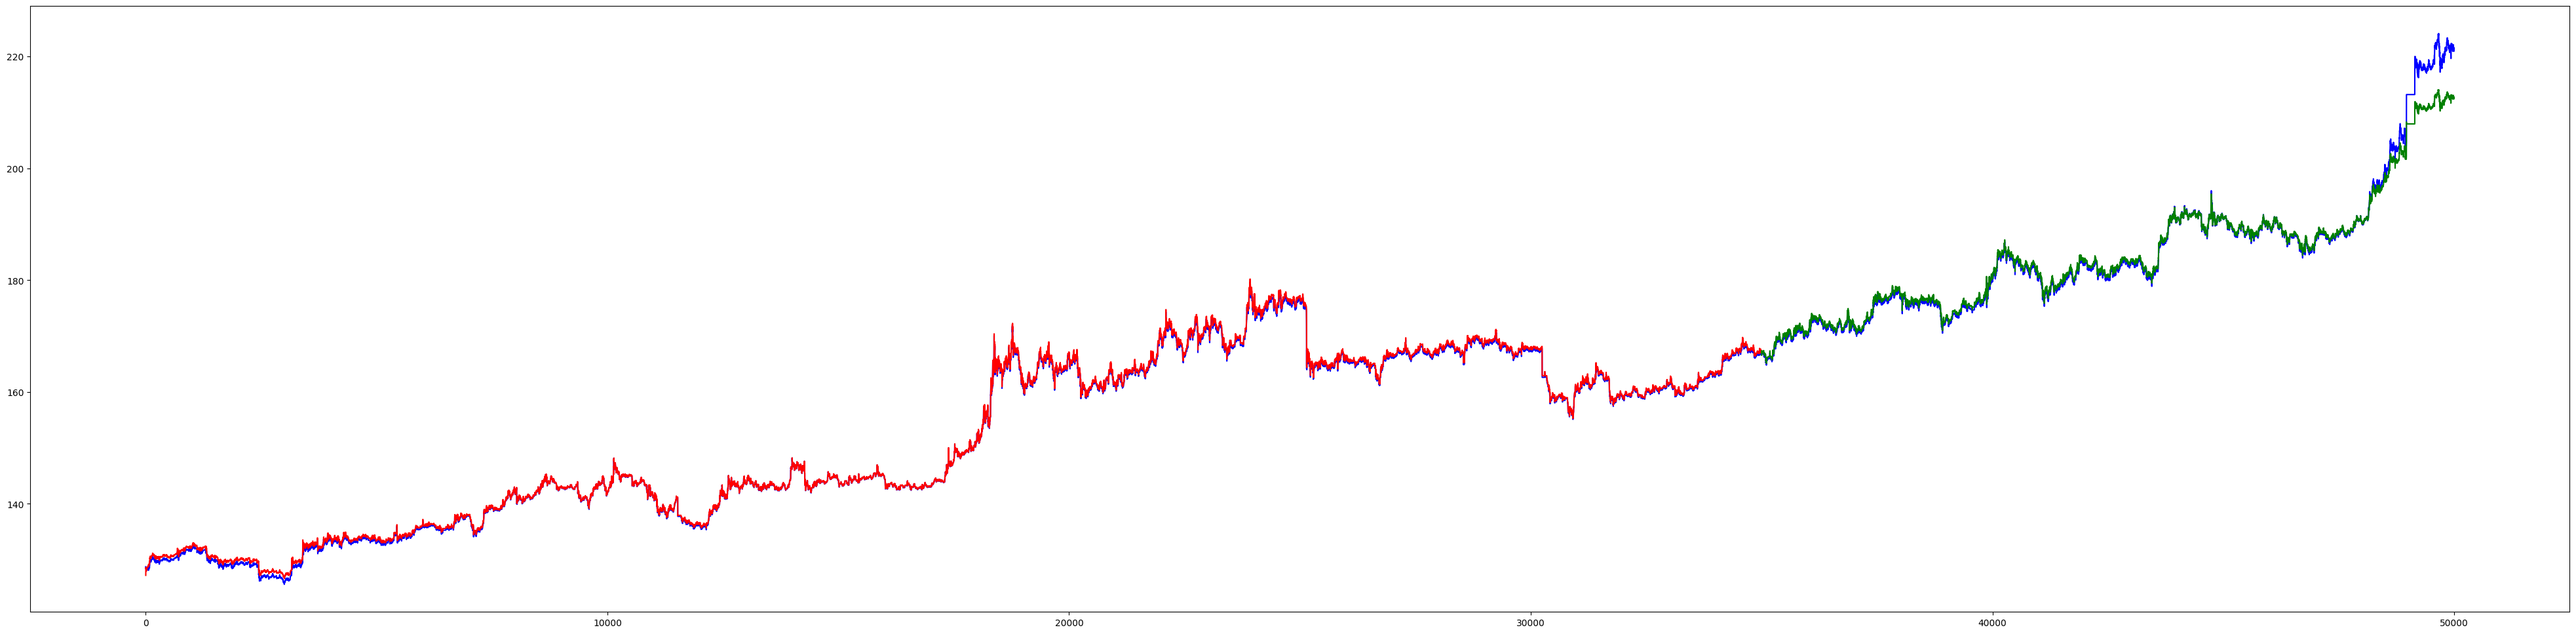

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def smape_score(actual, predicted) -> float: 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual)) / 2) 
        ), 3
    ) 

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]

    print("SMAPE:", smape_score(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("R2:", r2_score(true, pred))

def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(data)    
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred
        
    print("LSTM metrics: ")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)

По метрикам показало себе чуть лучше, чем классические модели.

MAE, MSE, RMSE в целом очень малы (< 5), что является отличным результатом.
SMAPE показал себя наилучшим образом, меньше 1 и даже близко к нулю, что очень приятно.

R2 ~= 0.96, что очень близко к единице, что очевидно является хорошим показателем.

#### DeepAR

DeepAR - это модель для прогнозирования временных рядов, разработанная компанией Amazon и представленная в их сервисе глубокого обучения Amazon Forecast. Эта модель основана на рекуррентной нейронной сети (RNN) и специально предназначена для работы с временными рядами, учитывая их динамику и внутренние зависимости.

Подготовим данные для подачи на вход нейросети.

In [2]:
file_path = 'data/gemini_ETHUSD_2020_1min.csv'
data = pd.read_csv(file_path, index_col=False)
del data['Symbol']
del data['Unix Timestamp']
del data['Volume']

data = data.iloc[::-1].reset_index(drop=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(data['Date'], inplace=True)

data = data[:50000]

In [3]:
data

,Date,Open,High,Low,Close
Date,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,128.84,128.84,128.74,128.74
2020-01-01 00:01:00,2020-01-01 00:01:00,128.74,128.74,128.74,128.74
2020-01-01 00:02:00,2020-01-01 00:02:00,128.74,128.74,128.74,128.74
2020-01-01 00:03:00,2020-01-01 00:03:00,128.74,128.74,128.74,128.74
2020-01-01 00:04:00,2020-01-01 00:04:00,128.74,128.74,128.49,128.50
...,...,...,...,...,...
2020-02-07 17:13:00,2020-02-07 17:13:00,221.39,221.40,221.24,221.24
2020-02-07 17:14:00,2020-02-07 17:14:00,221.24,221.26,221.24,221.26
2020-02-07 17:15:00,2020-02-07 17:15:00,221.26,221.48,221.26,221.48


In [48]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

df = {
    "start": data.index[0],
    "target": data['Open'].values, 
    "feat_dynamic_real": [data[col].values for col in data.columns if col != 'Open']
}
train_ds = ListDataset([df], freq='S')
test_size = 5000
train, test = split(train_ds, offset=test_size)

In [49]:
train, test

(TrainingDataset(dataset=[{'start': Period('2020-01-01 00:00:00', 'S'), 'target': array([128.84, 128.74, 128.74, ..., 221.26, 221.48, 221.4 ], dtype=float32), 'feat_dynamic_real': array([[1.5778368e+18, 1.5778368e+18, 1.5778370e+18, ..., 1.5810957e+18,
         1.5810958e+18, 1.5810958e+18],
        [1.2884000e+02, 1.2874001e+02, 1.2874001e+02, ..., 2.2148000e+02,
         2.2148000e+02, 2.2139999e+02],
        [1.2874001e+02, 1.2874001e+02, 1.2874001e+02, ..., 2.2125999e+02,
         2.2139999e+02, 2.2139999e+02],
        [1.2874001e+02, 1.2874001e+02, 1.2874001e+02, ..., 2.2148000e+02,
         2.2139999e+02, 2.2139999e+02]], dtype=float32)}], splitter=OffsetSplitter(offset=5000)),
 TestTemplate(dataset=[{'start': Period('2020-01-01 00:00:00', 'S'), 'target': array([128.84, 128.74, 128.74, ..., 221.26, 221.48, 221.4 ], dtype=float32), 'feat_dynamic_real': array([[1.5778368e+18, 1.5778368e+18, 1.5778370e+18, ..., 1.5810957e+18,
         1.5810958e+18, 1.5810958e+18],
        [1.288400

Создадим и обучим модель.

In [6]:
EPOCHS = 100
model = DeepAREstimator(freq='S', prediction_length=test_size, trainer_kwargs={'max_epochs':EPOCHS})

In [7]:
predictor = model.train(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                           | Out sizes     
----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | [[1, 1], [1, 1], [1, 5181, 7], [1, 5181], [1, 5181], [1, 5000, 7]] | [1, 100, 5000]
----------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)


Epoch 0: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=4.960]

Epoch 0, global step 50: 'train_loss' reached 4.96153 (best 4.96153), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=3.290]

Epoch 1, global step 100: 'train_loss' reached 3.29321 (best 3.29321), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=2.860]

Epoch 2, global step 150: 'train_loss' reached 2.86474 (best 2.86474), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=2.650]

Epoch 3, global step 200: 'train_loss' reached 2.64701 (best 2.64701), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=2.920]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=2.790]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=2.760]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=2.150]

Epoch 7, global step 400: 'train_loss' reached 2.14685 (best 2.14685), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=3.350]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=3.640]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=2.500]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=2.780]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=2.870]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [01:37<00:00,  0.51it/s, v_num=5, train_loss=2.710]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [01:36<00:00,  0.52it/s, v_num=5, train_loss=2.670]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [01:36<00:00,  0.52it/s, v_num=5, train_loss=2.600]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [01:35<00:00,  0.52it/s, v_num=5, train_loss=2.530]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [01:35<00:00,  0.52it/s, v_num=5, train_loss=2.510]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=2.490]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.940]

Epoch 19, global step 1000: 'train_loss' reached 1.94047 (best 1.94047), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.760]

Epoch 20, global step 1050: 'train_loss' reached 1.75874 (best 1.75874), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.760]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.730]

Epoch 22, global step 1150: 'train_loss' reached 1.73414 (best 1.73414), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.740]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [01:38<00:00,  0.51it/s, v_num=5, train_loss=1.740]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [01:40<00:00,  0.50it/s, v_num=5, train_loss=1.730]

Epoch 25, global step 1300: 'train_loss' reached 1.73222 (best 1.73222), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [01:38<00:00,  0.51it/s, v_num=5, train_loss=1.730]

Epoch 26, global step 1350: 'train_loss' reached 1.72620 (best 1.72620), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [01:36<00:00,  0.52it/s, v_num=5, train_loss=1.730]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [01:34<00:00,  0.53it/s, v_num=5, train_loss=1.720]

Epoch 28, global step 1450: 'train_loss' reached 1.71518 (best 1.71518), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [01:34<00:00,  0.53it/s, v_num=5, train_loss=1.730]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.720]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.710]

Epoch 31, global step 1600: 'train_loss' reached 1.71082 (best 1.71082), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [01:33<00:00,  0.53it/s, v_num=5, train_loss=1.720]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.720]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [01:33<00:00,  0.53it/s, v_num=5, train_loss=1.700]

Epoch 34, global step 1750: 'train_loss' reached 1.70470 (best 1.70470), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.700]

Epoch 35, global step 1800: 'train_loss' reached 1.70217 (best 1.70217), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [01:33<00:00,  0.53it/s, v_num=5, train_loss=1.700]

Epoch 36, global step 1850: 'train_loss' reached 1.69973 (best 1.69973), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [01:33<00:00,  0.54it/s, v_num=5, train_loss=1.690]

Epoch 37, global step 1900: 'train_loss' reached 1.69206 (best 1.69206), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.720]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=1.690]

Epoch 39, global step 2000: 'train_loss' reached 1.69005 (best 1.69005), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.710]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.710]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.690]

Epoch 42, global step 2150: 'train_loss' reached 1.68830 (best 1.68830), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.700]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.680]

Epoch 44, global step 2250: 'train_loss' reached 1.68470 (best 1.68470), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=44-step=2250.ckpt' as top 1


Epoch 45: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.680]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.680]

Epoch 46, global step 2350: 'train_loss' reached 1.67855 (best 1.67855), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.680]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [01:33<00:00,  0.54it/s, v_num=5, train_loss=1.680]

Epoch 48, global step 2450: 'train_loss' reached 1.67696 (best 1.67696), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [01:33<00:00,  0.54it/s, v_num=5, train_loss=1.690]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.680]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |          | 50/? [01:30<00:00,  0.56it/s, v_num=5, train_loss=1.680]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.690]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=1.690]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.670]

Epoch 54, global step 2750: 'train_loss' reached 1.67360 (best 1.67360), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=54-step=2750.ckpt' as top 1


Epoch 55: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.680]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=1.680]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=1.690]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=1.680]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.670]

Epoch 59, global step 3000: 'train_loss' reached 1.66764 (best 1.66764), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=59-step=3000.ckpt' as top 1


Epoch 60: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.660]

Epoch 60, global step 3050: 'train_loss' reached 1.65842 (best 1.65842), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=60-step=3050.ckpt' as top 1


Epoch 61: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.660]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.630]

Epoch 62, global step 3150: 'train_loss' reached 1.62952 (best 1.62952), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [01:34<00:00,  0.53it/s, v_num=5, train_loss=1.630]

Epoch 63, global step 3200: 'train_loss' reached 1.62881 (best 1.62881), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=63-step=3200.ckpt' as top 1


Epoch 64: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=1.630]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=1.640]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.640]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.640]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [01:33<00:00,  0.54it/s, v_num=5, train_loss=1.620]

Epoch 68, global step 3450: 'train_loss' reached 1.62342 (best 1.62342), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=68-step=3450.ckpt' as top 1


Epoch 69: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.610]

Epoch 69, global step 3500: 'train_loss' reached 1.60599 (best 1.60599), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=69-step=3500.ckpt' as top 1


Epoch 70: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=1.610]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [01:37<00:00,  0.51it/s, v_num=5, train_loss=1.640]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |          | 50/? [01:33<00:00,  0.53it/s, v_num=5, train_loss=1.620]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [01:34<00:00,  0.53it/s, v_num=5, train_loss=1.600]

Epoch 73, global step 3700: 'train_loss' reached 1.59911 (best 1.59911), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=73-step=3700.ckpt' as top 1


Epoch 74: |          | 50/? [01:34<00:00,  0.53it/s, v_num=5, train_loss=1.600]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.610]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [01:33<00:00,  0.54it/s, v_num=5, train_loss=1.590]

Epoch 76, global step 3850: 'train_loss' reached 1.58543 (best 1.58543), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=76-step=3850.ckpt' as top 1


Epoch 77: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.610]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.580]

Epoch 78, global step 3950: 'train_loss' reached 1.57913 (best 1.57913), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=78-step=3950.ckpt' as top 1


Epoch 79: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.590]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.590]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.590]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [01:30<00:00,  0.56it/s, v_num=5, train_loss=1.590]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.590]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.590]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=1.610]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [01:30<00:00,  0.56it/s, v_num=5, train_loss=1.600]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.570]

Epoch 87, global step 4400: 'train_loss' reached 1.57084 (best 1.57084), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=87-step=4400.ckpt' as top 1


Epoch 88: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=1.590]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [01:30<00:00,  0.55it/s, v_num=5, train_loss=1.590]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [01:29<00:00,  0.56it/s, v_num=5, train_loss=1.590]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.600]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [01:31<00:00,  0.54it/s, v_num=5, train_loss=1.590]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.530]

Epoch 93, global step 4700: 'train_loss' reached 1.53211 (best 1.53211), saving model to 'c:\\Users\\Иван\\Desktop\\timeseries_hw\\timeseries_homeworks\\final_project\\lightning_logs\\version_5\\checkpoints\\epoch=93-step=4700.ckpt' as top 1


Epoch 94: |          | 50/? [01:34<00:00,  0.53it/s, v_num=5, train_loss=1.550]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [01:33<00:00,  0.53it/s, v_num=5, train_loss=1.570]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [01:32<00:00,  0.54it/s, v_num=5, train_loss=1.550]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [01:30<00:00,  0.56it/s, v_num=5, train_loss=1.560]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.580]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.580]

Epoch 99, global step 5000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [01:31<00:00,  0.55it/s, v_num=5, train_loss=1.580]


Сделаем предсказания.

In [50]:
test = test.generate_instances(prediction_length = test_size, windows=1)
forecast = list(predictor.predict(test.input))

In [51]:
forecast

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[134.42125, 135.39012, 133.84372, ..., 154.01949, 154.408  ,
         153.60234],
        [132.11194, 131.9282 , 133.91191, ..., 153.6669 , 152.71707,
         153.15636],
        [134.90765, 133.57635, 133.52148, ..., 155.24503, 155.97874,
         154.70654],
        ...,
        [132.95296, 134.36458, 135.3756 , ..., 153.76622, 153.88576,
         154.96692],
        [134.05112, 133.58426, 133.17743, ..., 154.54146, 154.8319 ,
         153.69925],
        [133.08981, 133.45047, 133.79918, ..., 154.16272, 154.61424,
         153.53644]], dtype=float32), start_date=Period('2020-01-01 01:23:20', 'S'))]

In [52]:
len(test.dataset[0]['target'])

50000

Отрисуем предсказания и посчитаем метрики.

ValueError: x and y must have same first dimension, but have shapes (50000,) and (5000,)

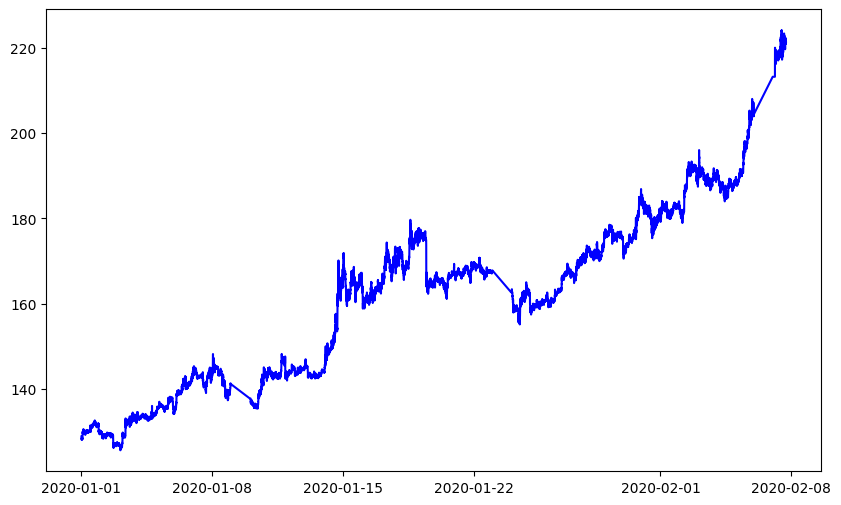

In [53]:
import matplotlib.pyplot as plt
from gluonts.evaluation import make_evaluation_predictions

test_dataset = test.dataset[0]  # Extracting the first (and possibly the only) dataset

# Extracting the true labels and predictions
true_labels = test_dataset['target']
predicted = forecast[0].samples.mean(axis=0)  # Assuming forecast is the list of predictions

# Get the length of the test data
test_length = len(true_labels)

# Assuming 'data' is your original DataFrame and 'test_size' is the length of the test data
time_index = data.index[-test_length:]  # Adjusted to match the length of true_labels

# Plotting predictions and true values
plt.figure(figsize=(10, 6))
plt.plot(time_index, true_labels, label='Actual', color='blue')
plt.plot(time_index, predicted[:test_length], label='Forecast', color='red')  # Truncate predicted to match length

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predictions vs True Labels')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def smape_score(actual, predicted) -> float: 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual)) / 2) 
        ), 3
    ) 

print("RMSE:", np.sqrt(mean_squared_error(data['Open'][len(data['Open']) - len(forecast[0].samples[0]):len(data['Open'])], forecast[0].samples[0])))
print("SMAPE:", smape_score(data['Open'][len(data['Open']) - len(forecast[0].samples[0]):len(data['Open'])], forecast[0].samples[0]))
print("MAE:", mean_absolute_error(data['Open'][len(data['Open']) - len(forecast[0].samples[0]):len(data['Open'])], forecast[0].samples[0]))
print("R2: ", r2_score(data['Open'][len(data['Open']) - len(forecast[0].samples[0]):len(data['Open'])], forecast[0].samples[0]))

RMSE: 48.32018793584393
SMAPE: 0.27
MAE: 47.02255229797363
R2:  -14.700951370842064


#### TCN

TCN (Temporal Convolutional Network) - это тип нейронной сети, предназначенный для работы с последовательными данных, такими как временные ряды. Эта архитектура основана на использовании сверточных слоев для извлечения признаков из последовательных данных.

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tcn import TCN

df_tcn = data

ImportError: Could not find the DLL(s) 'msvcp140_1.dll'. TensorFlow requires that these DLLs be installed in a directory that is named in your %PATH% environment variable. You may install these DLLs by downloading "Microsoft C++ Redistributable for Visual Studio 2015, 2017 and 2019" for your platform from this URL: https://support.microsoft.com/help/2977003/the-latest-supported-visual-c-downloads